***
<center><img src='https://github.com/HesamAsad/HesamAsad.github.io/blob/main/images/LOGO_EN_blue.png?raw=true' width=250/></center>

# <center>
## <center><span style='font-family:"Times New Roman"'><span style='background:dark'>  <font color='#1966ab'>$\LARGE{\text{Sharif University of Technology}}$</font>  <br>  <br>  <font color='#FFFFCC'>$\Large{\text{Masoud Tahmasbi}}$ </font> <br> <font color='#FFFFCC'>$\normalsize {\text{Student ID: } 402200275}$ </font>  <br>  <br> <font color='#33FFCC'>$\large{\text{CE957: Reinforcement Learning}}$</font> <br>  <font color='#FFFF00'>$\normalsize{\text{Assignment #2 - DQN}}$ </font>
<br>

***

In this notebook we learn how to use PyTorch to train a Deep Q-Learning (DQN) agent on the [LunarLander-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/) task from [Gymnasium](https://gymnasium.farama.org/).

# Setup

We must first install the required packages.

In [ ]:
!sudo apt-get update --quiet
!pip install imageio --quiet
!sudo apt-get install -y xvfb ffmpeg --quiet
!pip install swig --quiet
!pip install gymnasium[box2d] --quiet

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [61.3 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,375 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubunt

Next we must import the following libraries.

In [ ]:
import gymnasium as gym
import random
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from collections import namedtuple, deque

import base64
import json
import imageio
import IPython

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Here are some helper functions which will allow you to plot the training process and see the results by visualizing the gym environment.

In [ ]:
# @title helper functions

# disable warnings
import logging
logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)


def plot_rewards(sum_of_rewards, show_result=False):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def create_policy_eval_video(env, agent, filename, num_episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                state = torch.from_numpy(state).unsqueeze(0).to(device)
                action = agent.act(state, greedy=True)
                state, reward, terminated, truncated, info = env.step(action.item())
                video.append_data(env.render())
                if terminated or truncated:
                    break
    return embed_mp4(filename)


def save_progress(sum_of_rewards, PATH):
    # Convert the list to a JSON string
    json_data = json.dumps(sum_of_rewards)
    # Write the JSON data to a file
    with open(PATH + str('.json'), "w") as file:
        file.write(json_data)


def load_progress(PATH):
    with open(PATH + str('.json'), "r") as file:
        json_data = file.read()
    # Load the JSON data back into a Python list
    return json.loads(json_data)

# Explore the Environment (10 points)

First we must create the environment. In order to be able to render the environment we must use `rgb_array` as the render mode.

In [ ]:
env = gym.make("LunarLander-v2", render_mode='rgb_array')

# TODO: Print the observation space and action space
print('Observations:', env.observation_space)
print('Actions:', env.action_space)

Observations: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Actions: Discrete(4)


Complete the following class to have an agen which acts according to a random policy (randomly selects actions from the action space).

In [ ]:
class RandomAgent(object):

    def __init__(self):
        self.action_space_size = 4

    def act(self, state, greedy=None):
        # TODO: Select and return a random action
        return random.choice(np.arange(self.action_space_size)) #########################

Visualize the random policy.

In [ ]:
random_agent = RandomAgent()

create_policy_eval_video(env, random_agent, 'random_policy', num_episodes=5)

To learn more about this environment you can visit [here](https://gymnasium.farama.org/environments/box2d/lunar_lander/). Learning more about the environment is strongly recommended as it allows you to better understand the performance of your model.

# Replay Memory (15 points)

We'll be using experience replay memory for training our DQN. It stores the experiences that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the experiences that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

For this, we're going to need a `ReplayMemory`: a cyclic buffer of bounded size that holds the experiences observed recently.

In order to implement the `ReplayMemory` we use the [deque](https://docs.python.org/3/library/collections.html#deque-objects) data structure to store the experiences.
We store each experience as a [namedtuple](https://docs.python.org/3/library/collections.html#collections.namedtuple) which will consist of state, action, next_state, reward, and done status of previous transitions.

Using the `.push` method we add new experiences to the memory. If the number of experiences exceed the maximum length of the memory (a.k.a. the capacity), the first experiences added to the memory will be removed to make space for the new experiences.

We also need to implement a `.sample` method for selecting a random batch of experiences for training. In this method we first sample a batch from the memory. Next we concatenate states, actions, reward, next_state, and done batches and then we return them.

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity, batch_size):
        self.memory = deque([], maxlen=capacity)
        self.batch_size = batch_size
        transition_tuple = ('state', 'action', 'reward', 'next_state', 'done')
        self.experience = namedtuple('Experience', transition_tuple)

    def push(self, state, action, reward, next_state, done):
        # TODO: Save an experience
        new_experience = self.experience(state, action, reward, next_state, done)
        self.memory.append(new_experience)

    def sample(self):
        # TODO: Sample a batch from memory
        batch = random.sample(self.memory, k=self.batch_size)
        # TODO: Concatenate state, action, reward, next_state, and done batches
        states = torch.from_numpy(np.vstack([b.state.cpu() for b in batch if b is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([b.action for b in batch if b is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([b.reward.cpu() for b in batch if b is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([b.next_state.cpu() for b in batch if b is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([b.done.cpu() for b in batch if b is not None]).astype(np.uint8)).float().to(device)
        # Return the concatenated values
        return states, actions, rewards, next_states, dones

    def __len__(self):
        # TODO: Return length of memory
        return len(self.memory)

# Deep Q-Network (10 points)

Here we define the architecture of our Q-Network. In short, the network will try to predict the expected return of taking each action given its input which is the current state.

In [ ]:
class QNetwork(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(QNetwork, self).__init__()
        self.layer_stack_1 = nn.Sequential(
            nn.Linear(in_features=n_observations, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=n_actions)
        )

    def forward(self, x):
        return self.layer_stack_1(x)

# Agent (40 points)

In this part we must design our Agent class which is the must important part of the notebook. First let's take a look at its methods:


*   `__init__` : initializes the agent, by receiving it the q_network, replay memory, optimize, criterion, and a dictionary of paramters which hold the hyperparameters of the agent.
*   `step` : allows the agent to store an experience in its memory and if necessary, it initiates the learning process.
*   `act` : by receiving a state and boolean value for choosing a greedy action, if the boolean value is false, it selects an $\varepsilon$-greedy action by passing the state to the policy network of the agent, and select the action with the highest state-action value. The $\varepsilon$ value is calculated using the following formula: $$\varepsilon = \varepsilon_{end} + \left(\varepsilon_{start} - \varepsilon_{end}\right)\exp\left(-\frac{\text{steps done}}{\text{decay rate}}\right)$$
*   `learn` : first computes the predicted Q-values for the observed states and actions using the policy network. Then, it computes the expected Q-values for the next states by evaluating the target network, incorporating rewards and discount factors. After computing the loss between predicted and expected Q-values, the function optimizes the model parameters using gradient descent. Additionally, it calls the soft update function to gradually update the target network's parameters towards the policy network's parameters.
*   `soft_update` : The target network is updated at every step with a soft update controlled by the hyperparameter $\tau$, which was previously defined. The target is updated according to: $$\theta' \leftarrow \tau \theta + (1 - \tau) \theta'$$ where $\theta'$ are the parameters of the target network and $\theta$ are the parameters of the policy network.
*   `save` and `load` : are used for saving and loading the policy and target networks of the agent.

In [ ]:
class Agent(object):

    def __init__(self, QNetwork, memory, optimizer, criterion, params):
        # TODO: Create policy and target nets based on the q-net
        self.n_observations = 8
        self.n_actions = 4
        self.policy_network = QNetwork(self.n_observations, self.n_actions).to(device)
        self.target_network = QNetwork(self.n_observations, self.n_actions).to(device)
        # TODO: Setup the agent's memory
        self.memory = memory(capacity=params['BUFFER_SIZE'],
                             batch_size=params['BATCH_SIZE'])
        # criterion, optimizer and params
        self.criterion = criterion
        self.optimizer = optimizer(self.policy_network.parameters(), lr=params['LR'], amsgrad=True)
        self.tau = params['TAU']
        self.gamma = params['GAMMA']
        self.update_rate = params['UPDATE_RATE']
        self.eps = {'START': params['EPS_START'], 'END': params['EPS_END'], 'DECAY': params['EPS_DECAY']}
        # Set steps counter to zero
        self.steps_done = 0

    def step(self, state, action, reward, next_state, done):
        # TODO: Save the experience in the memory of the agent
        self.memory.push(state, action, reward, next_state, done)
        # TODO: Increment the steps counter
        self.steps_done += 1
        if self.steps_done % self.update_rate == 0 and len(self.memory) > self.memory.batch_size:
            # TODO: Sample a batch from memory and learn from it
            states, actions, rewards, next_states, dones = self.memory.sample()
            self.learn(states, actions, rewards, next_states, dones)

    def act(self, state, greedy=False):
        eps_threshold = self.eps['END'] + (self.eps['START'] - self.eps['END']) * np.exp(- self.steps_done / self.eps['DECAY'])
        if greedy or random.random() > eps_threshold:
            self.policy_network.eval()
            with torch.no_grad(): # TODO: Select greedy action
                actions = self.policy_network(state)
            self.policy_network.train()

            return np.argmax(actions.cpu().data.numpy())
        else: # TODO: Select random action
            return random.choice(np.arange(self.n_actions))

    def learn(self, states, actions, rewards, next_states, dones):
        # TODO: Compute the predicted Q-values using the policy network
        Q_predicted = self.policy_network(states).gather(1, actions)
        # TODO: Compute expected Q-values using the target network (don't forget to use no_grad)
        with torch.no_grad():
            Q_target_to_go = self.target_network(next_states).detach().max(1)[0].unsqueeze(1)
        # TODO: Compute the expected Q-values
        Q_target = rewards + self.gamma * Q_target_to_go * (1-dones)
        # TODO: Compute the loss
        loss = self.criterion(Q_predicted, Q_target)
        # TODO: Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # TODO: Run soft update
        self.soft_update()

    def soft_update(self):
        # TODO: Soft update of all weights in the target network
        for target_network_param, policy_network_param in zip(self.target_network.parameters(), self.policy_network.parameters()):
            target_network_param.data.copy_(self.tau * policy_network_param.data + (1.0 - self.tau) * target_network_param.data)

    def save(self, PATH):
        torch.save(self.policy_network, PATH + '_policy.pt')
        torch.save(self.target_network, PATH + '_target.pt')

    def load(self, PATH):
        self.policy_network = torch.load(PATH + '_policy.pt')
        self.target_network = torch.load(PATH + '_target.pt')

# Training (15 points)

In order to train the ageant, you must first define the hyperparameters of the agent.

In [ ]:
params = {
    'UPDATE_RATE': 4 ,    # how often to update the network
    'BUFFER_SIZE': int(1e5) ,    # size of the replay buffer
    'BATCH_SIZE': 64 ,     # number of experiences sampled from memory
    'GAMMA': 0.99,          # discount factor
    'EPS_START': 1,      # starting value of epsilon
    'EPS_END': 0.01,        # final value of epsilon
    'EPS_DECAY': 0.8 ,      # rate of exponential decay of epsilon
    'TAU': 5e-3 ,            # update rate of the target network
    'LR': 5e-3               # learning rate of the optimizer
}

# Set the environment
env = gym.make("LunarLander-v2")
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

sum_of_rewards = list()

# TODO: Choose optimizer and loss function
optimizer = optim.Adam
criterion = F.mse_loss

# TODO: Get an instance of the agent class
agent = Agent(QNetwork, ReplayMemory, optimizer, criterion, params)

Now that we have set the hyperparameters, we can proceed to train the agent. For your convenience, the following code segment has been written in a way which allows you to train your model for more episodes with a simple re-run. If you feel the agent hasn't yet achieved good results, you can simply run the following segment again to train it for more episodes.

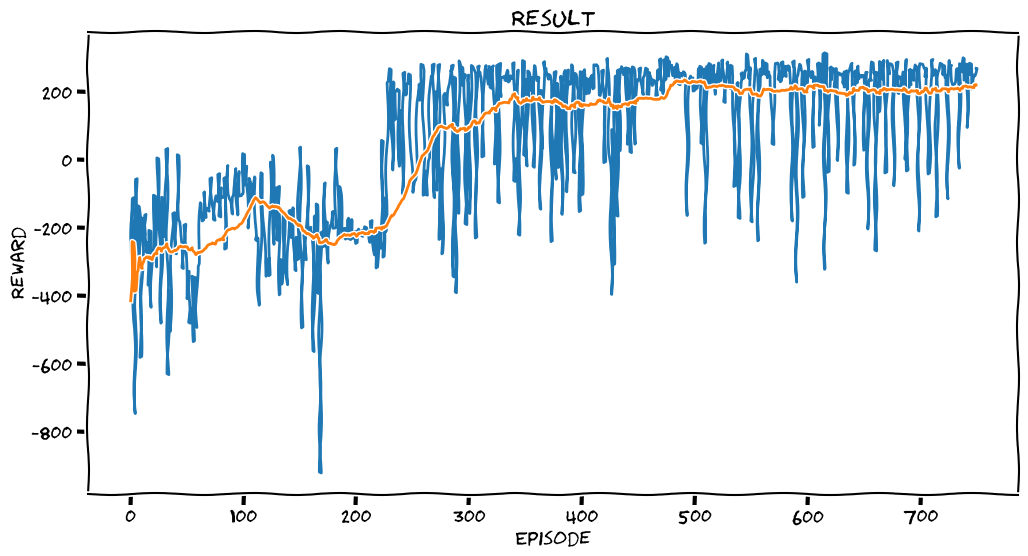

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [ ]:
num_episodes = 750
max_iteration = 2000
for i_episode in range(1, num_episodes + 1):
    # TODO: Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    episode_reward, done = 0, False
    iteration = 0
    while not done:
        # TODO: Take an Ɛ-greedy action
        action = agent.act(state, greedy=False)
        # TODO: Take a step in the environment
        next_state, reward, done, _, _ = env.step(action)
        # TODO: Update sum of rewards for current episode
        episode_reward += reward
        # TODO: Convert reward to tensor
        reward = torch.tensor(reward, dtype=torch.float32, device=device).unsqueeze(0)
        # TODO: Convert the next state into tensor
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
        # TODO: Store the termination status into a tensor
        if done: done_tensor = torch.tensor([1], dtype=torch.float32, device=device).unsqueeze(0)
        else: done_tensor = torch.tensor([0], dtype=torch.float32, device=device).unsqueeze(0)
        # TODO: Store the experience in memory
        agent.step(state, action, reward, next_state, done_tensor)
        # TODO: Update done status
        iteration += 1
        if done or iteration > max_iteration:
            break
        # TODO: Move to the next state
        state = next_state
    # Update and plot rewards
    sum_of_rewards.append(episode_reward)
    plot_rewards(sum_of_rewards)
    # Save model every 100 episodes (change the rate if needed)
    if i_episode % 100 == 0:
        path = 'DQN_' + str(len(sum_of_rewards)).zfill(4)
        agent.save(path)
        save_progress(sum_of_rewards, path)

plot_rewards(sum_of_rewards, show_result=True)
plt.ioff()
plt.show()

# Evaluate the Model (10 points)

In order to evaluate the model, we use the following function to measure the average reward and it's standard deviation.

In [ ]:
def evaluate_policy(env, agent, num_episodes=10):
    # TODO: Initialize sum of rewards
    sum_of_rewards = np.zeros(num_episodes)
    # max_iteration = 500
    for episode in range(num_episodes):
      # TODO: Initialize environment
      print(f'Episode {episode}')
      done = False
      state, info = env.reset()
      state_tensor = torch.from_numpy(state)
      # TODO: Run policy
      iteration = 0
      while not done:
        iteration += 1
        action = agent.act(state_tensor, greedy=True)
        next_state, reward, done, _, _ = env.step(action)
        sum_of_rewards[episode] += reward
        state_tensor = torch.from_numpy(next_state)
        # TODO: Break if terminated or truncated
        if done or max_iteration < iteration:
            break
    # TODO: Return mean and std of rewards
    return np.mean(sum_of_rewards), np.std(sum_of_rewards)

In [ ]:
mean_reward, std_reward = evaluate_policy(env, agent)
print(f"mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

Episode 0
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
mean_reward = 269.88 +/- 21.8410


Show how the learned policy works.

In [ ]:
env = gym.make("LunarLander-v2", render_mode='rgb_array')
create_policy_eval_video(env, agent, 'greedy_policy', 3)